In [1]:
import sys
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('..')
from src.utils.factory import read_yaml
from src.dataset.dataset import MakeDataset
from src.models.networks import read_model
from src.ntk.generate import generate_ntk
from src.tools.relative_frob import calc_ntk_frob

### Read Settings

In [2]:
cfg = read_yaml(fpath='../src/config/config.yaml')

# for adjust the number of train data D * 0.8 (train ratio) = ?
cfg.DATA.DATA_NUM = 100

# setting training epoch
cfg.GENERAL.EPOCH = 2**17

In [3]:
X_train, X_test, y_train, y_test = MakeDataset(cfg).get_tensor()
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.DATA.DATA_NUM)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=cfg.DATA.DATA_NUM)

# architecture types
arch_types = ['gaussian', 'withmp', 'mexican', 'matern', 'vanilla']

# list of width of layer (16 ~ 2048)
mid_features_list = [2**i for i in range(4, 12)]

### Calculate Frobenius norm

In [4]:
frob_means, frob_stds = [], []
tr_acc_means, tr_acc_stds = [], []
te_acc_means, te_acc_stds = [], []
for arch in tqdm(arch_types):
    print(f'-------- Architecture: {arch}--------')
    cfg.INITIALIZER.TYPE = arch
    frob_mean, frob_std = [], []
    tr_acc_mean, tr_acc_std = [], []
    te_acc_mean, te_acc_std = [], []
    for i, mid_features in enumerate(mid_features_list):
        # setting parameters for each model
        if arch == 'gaussian':
            cfg.INITIALIZER.R_SIGMA = 0.5
            cfg.INITIALIZER.S_SIGMA = 0.01
        elif arch == 'withmp':
            cfg.INITIALIZER.R_SIGMA = 0.5
            cfg.INITIALIZER.S_SIGMA = 0.01
        elif arch == 'mexican':
            cfg.INITIALIZER.M_SIGMA = 0.5
            cfg.INITIALIZER.S_SIGMA = 0.01
        elif arch == 'matern':
            cfg.INITIALIZER.R_SIGMA = 0.5
            cfg.INITIALIZER.S_SIGMA = 0.01
        frobs_by_mid, tr_accs, te_accs = [], [], []
        for i in range(5):
            cfg.MODEL.MID_FEATURES = mid_features
            net = read_model(cfg)
            _, lr = generate_ntk(net, 0, X_train, X_test, cfg, calc_lr=True)
            frob, tr_acc, te_acc = calc_ntk_frob(cfg, net, lr, train_loader, test_loader)
            frobs_by_mid.append(frob)
            tr_accs.append(tr_acc)
            te_accs.append(te_acc)
        frob_mean.append(np.mean(frobs_by_mid))
        frob_std.append(np.std(frobs_by_mid))
        tr_acc_mean.append(np.mean(tr_accs))
        tr_acc_std.append(np.std(tr_accs))
        te_acc_mean.append(np.mean(te_accs))
        te_acc_std.append(np.std(te_accs))
    frob_means.append(frob_mean)
    frob_stds.append(frob_std)
    tr_acc_means.append(tr_acc_mean)
    tr_acc_stds.append(tr_acc_std)
    te_acc_means.append(te_acc_mean)
    te_acc_stds.append(te_acc_std)

  0%|          | 0/5 [00:00<?, ?it/s]

-------- Architecture: gaussian--------


100%|██████████| 80/80 [00:00<00:00, 108.70it/s]


-------- Architecture: withmp--------


100%|██████████| 80/80 [00:00<00:00, 247.86it/s]


-------- Architecture: mexican--------


100%|██████████| 80/80 [00:00<00:00, 108.26it/s]


-------- Architecture: matern--------


100%|██████████| 80/80 [00:00<00:00, 107.86it/s]


-------- Architecture: vanilla--------


100%|██████████| 80/80 [00:00<00:00, 108.07it/s]


### Visualize

In [5]:
def visualize_errorbar(means, stds, title, ylabel, frob=False):
    
    arch_legends = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
    x_ticks = ['$2^4$', '$2^5$', '$2^6$', '$2^7$', '$2^8$', '$2^9$', '$2^{10}$', '$2^{11}$']
    
    plt.figure(figsize=(12, 10))
    for i, arch in enumerate(arch_legends):
        plt.errorbar(x_ticks, means[i], yerr=stds[i], capsize=3, label=arch)
    plt.title(title, fontsize=30)
    plt.xlim(xmin=0, xmax=7)
    plt.xticks(np.arange(8), x_ticks, fontsize=25)
    plt.xlabel('Width of layer: n', fontsize=30)
    plt.yticks(fontsize=25)
    if frob:
        plt.ylabel(ylabel, fontsize=30)
        plt.yscale('log', base=2)
    plt.legend(fontsize=30)
    plt.tight_layout()

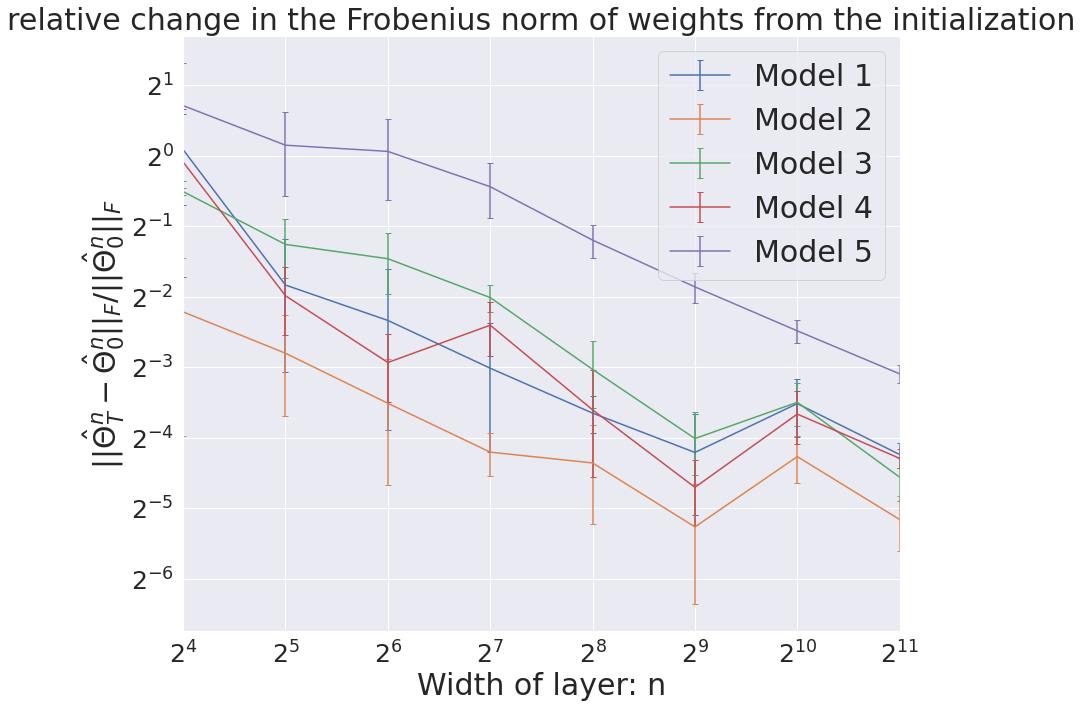

In [6]:
title = 'relative change in the Frobenius norm of weights from the initialization'
ylabel = '$||\hat{\Theta}_{T}^{n}-\hat{\Theta}_{0}^{n}||_F / ||\hat{\Theta}_{0}^{n}||_F$'
visualize_errorbar(frob_means, frob_stds, title, ylabel, frob=True)

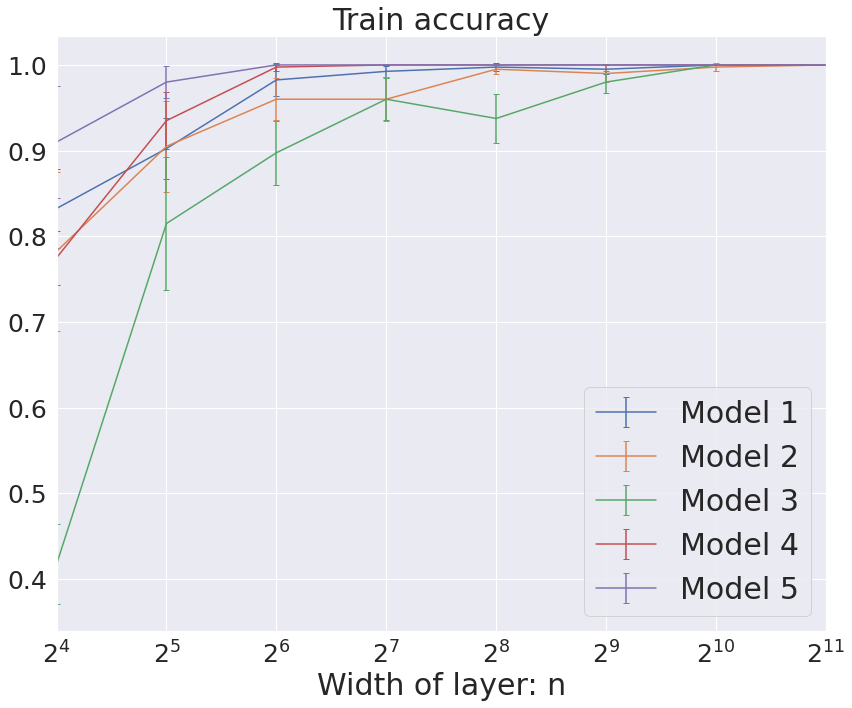

In [7]:
title = 'Train accuracy'
ylabel = ''
visualize_errorbar(tr_acc_means, tr_acc_stds, title, ylabel)

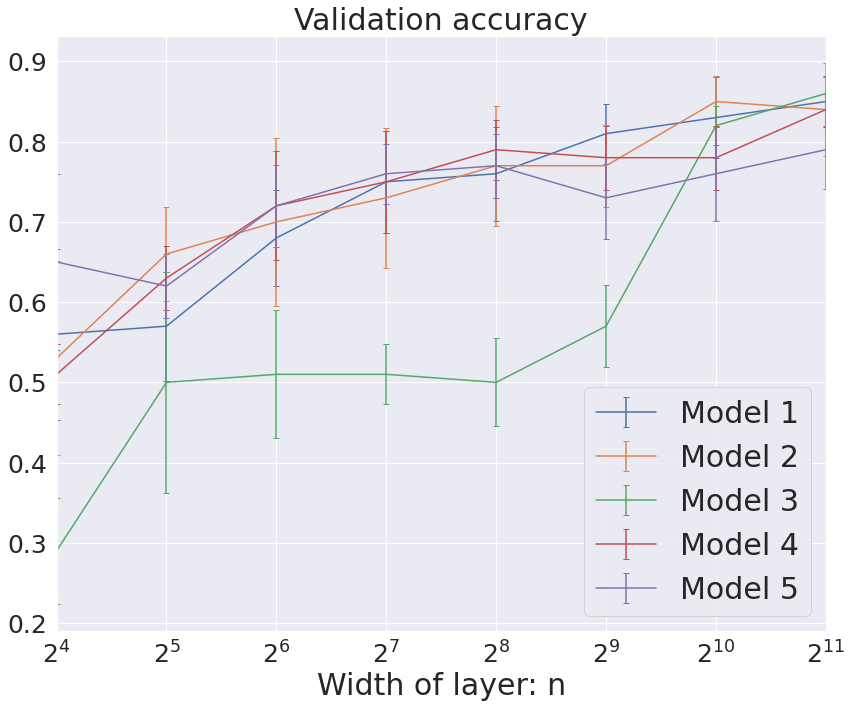

In [8]:
title = 'Validation accuracy'
ylabel = ''
visualize_errorbar(te_acc_means, te_acc_stds, title, ylabel)